In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import itertools
import os

In [2]:
#_PATH_DATASET = '../input/all/' # No borrar esto, por compatibilidad para correrlo con datasets en otros directorios
_PATH_DATASET = '/home/diego/Cursos/FIUBA/git/fiuba-trocafone-tp2-final-set/' # No borrar esto, por compatibilidad para correrlo con datasets en otros directorios

## Cargo los features

In [3]:
# Cargo los features para entrenamiento
new_vector_features = pd.read_csv(_PATH_DATASET + 'out_features_processed_train.csv')
new_vector_features = new_vector_features.set_index('person')

# Cargo los features para predicción
new_vector_features_to_predict = pd.read_csv(_PATH_DATASET + 'out_features_processed_to_predict.csv')
new_vector_features_to_predict = new_vector_features_to_predict.set_index('person')

> # Separación de test de entrenamiento y pruebas

In [4]:
cols = {'label':True, 'first_inter_to_june': True} # Elimino los false

In [75]:
# Borro columnas según diccionario
def get_x_data(new_vector_features, cols):
    if 'label' in new_vector_features.columns:
        x_data = new_vector_features.drop('label', axis = 1)
    else:
        x_data = new_vector_features
    for keys in cols.keys():
        if cols[keys] is False:
            x_data = x_data.drop(keys, axis = 1)
    return x_data, new_vector_features.label

In [7]:
x_data, y_labels = get_x_data(new_vector_features, cols)
x_features_to_predict, y_labels_to_predict = get_x_data(new_vector_features_to_predict, cols)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data,y_labels,test_size=0.3,random_state=101)

### Función que imprime la curva de precisión - recall

In [9]:
def plot_precision_and_recall(precision, recall, threshold):
    plt.clf()
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])
    plt.show()

### Función que crea la matriz de confusión

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.clf()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

> # Hago distintas pruebas

In [29]:
# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

## Stochastig gradient descent

In [12]:
'''
This estimator implements regularized linear models with stochastic
gradient descent (SGD) learning: the gradient of the loss is estimated
each sample at a time and the model is updated along the way with a
decreasing strength schedule (aka learning rate). SGD allows minibatch
(online/out-of-core) learning, see the partial_fit method.
For best results using the default learning rate schedule, the data should
have zero mean and unit variance.
'''
sgd = linear_model.SGDClassifier(max_iter=250, tol=None)
'''
Ajustar el clasificador
Fit linear model with Stochastic Gradient Descent.
'''
sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=250, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [13]:
'''
Returns the mean accuracy on the given test data and labels.

In multi-label classification, this is the subset accuracy
which is a harsh metric since you require for each sample that
each label set be correctly predicted.
'''
print("Score en training set", 100*sgd.score(X_train, y_train), "%")
print("Score en testing set", 100*sgd.score(X_test, y_test), "%")

Score en training set 94.9665170358 %
Score en testing set 94.9184549356 %


In [14]:
'''
Predict class labels for samples in X.
'''
y_pred = sgd.predict(X_test)
print("Como se ajustó el modelo a los datos de entrada? ", 100*sgd.score(X_test, y_pred))


Como se ajustó el modelo a los datos de entrada?  100.0


In [15]:
sum(abs(y_test ))

296

In [16]:
print(sum(abs(y_pred)))

0


In [17]:
print("Mi error calculado: ", 100*(1-sum(abs(y_pred - y_test))/y_pred.shape[0]))

Mi error calculado:  94.91845493562232


In [18]:
del y_pred

In [19]:
y_pred_unknown = sgd.predict(x_features_to_predict)

In [20]:
np.unique(y_pred_unknown)

array([0])

## Random Forests


In [23]:
def runRandomForests(X_train, y_train, X_test, y_test, n_estimators = 10):
    # Creo el objeto
    random_forest = RandomForestClassifier(n_estimators=n_estimators, oob_score=False)
    
    # Ajusto
    random_forest.fit(X_train, y_train)

    # Predigo
    Y_prediction = random_forest.predict(X_test)

    # Calculate the absolute errors
    errors = abs(Y_prediction - y_test)

    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    
    #random_forest.score(X_test, Y_prediction)
    acc_random_forest = round(random_forest.score(X_test, Y_prediction) * 100, 2)
    print(round(acc_random_forest,2,), "%")
    return random_forest

In [37]:
# Random Forest
n_estimators = 250
random_forest = runRandomForests(X_train, y_train, X_test, y_test, n_estimators = n_estimators)
y_prediction = random_forest.predict(X_test)

Mean Absolute Error: 0.05 degrees.
100.0 %


In [38]:
#f1 = f1_score(y_test, y_prediction,)

Confusion matrix, without normalization
[[5522    7]
 [ 293    3]]


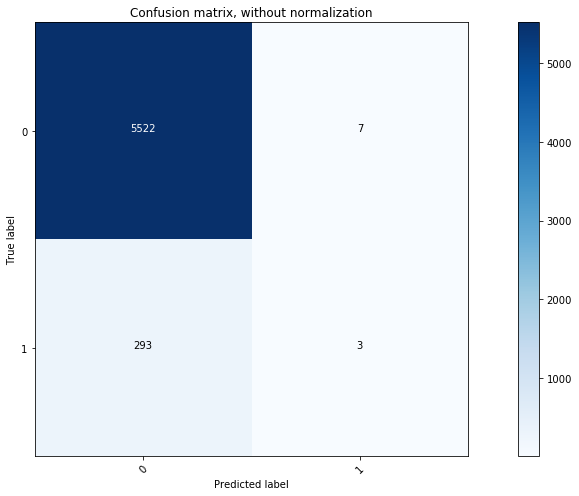

In [41]:
predictions = cross_val_predict(random_forest, X_test, y_test, cv=3)
cnf_matrix = confusion_matrix(y_test, predictions)
class_names = ['0', '1']
plt.figure(figsize=(14, 7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

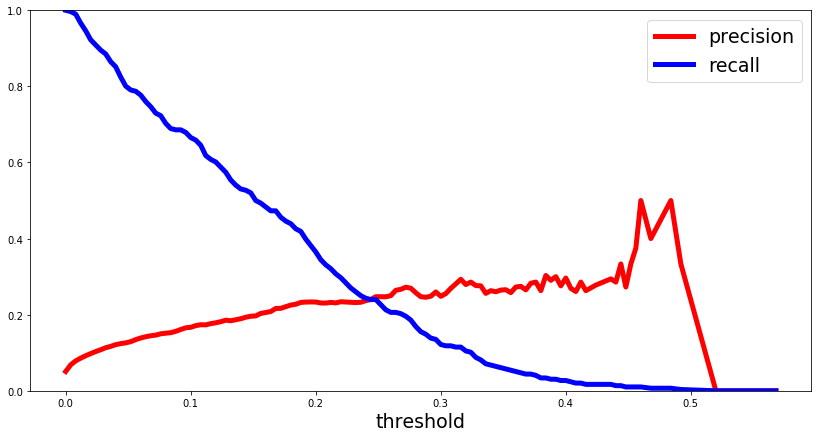

In [42]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores_orig = random_forest.predict_proba(X_test)
y_scores = y_scores_orig[:,1]
#y_scores = (y_scores_orig [:,1] >= threshold1).astype('int')
#Si no hay ningún 1 da Warning y no se plotea nada
precision, recall, threshold = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)

In [43]:
threshold1 = 0.2
y_scores_thresholded = (y_scores_orig [:,1] >= threshold1).astype('int')

In [44]:
y_pred_unknown = random_forest.predict_proba(x_features_to_predict)

In [45]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

In [66]:
importances.index[20:]

Index(['month4', '1.0', 'month3', 'conversion', 'staticpage', 'month1',
       'month2', '5.0', 'lead'],
      dtype='object', name='feature')

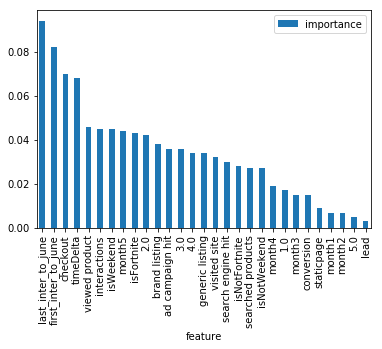

In [47]:
#plt.figure()
importances.plot.bar()
plt.show()

### Vuelvo a realizar RandomForests con menos features

In [77]:
# Borro los menos significativos
cols = {
    'month4': False, '1.0': False, 'month3': False, 'conversion': False, 'staticpage': False, 'month1': False,
    'month2': False, '5.0': False, 'lead': False}

In [78]:
x_data, y_labels = get_x_data(new_vector_features, cols)
x_features_to_predict, y_labels_to_predict = get_x_data(new_vector_features_to_predict, cols)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data,y_labels,test_size=0.3,random_state=101)

In [79]:
x_data.columns

Index(['timeDelta', 'last_inter_to_june', 'first_inter_to_june',
       'interactions', 'isNotWeekend', 'isWeekend', 'isFortnite',
       'isNotFortnite', 'month5', 'ad campaign hit', 'brand listing',
       'checkout', 'generic listing', 'search engine hit', 'searched products',
       'viewed product', 'visited site', '2.0', '3.0', '4.0'],
      dtype='object')

In [80]:
# Vuelvo a crear el objeto random_forest
# Random Forest
n_estimators = 250
random_forest = runRandomForests(X_train, y_train, X_test, y_test, n_estimators = n_estimators)
y_prediction = random_forest.predict(X_test)

Mean Absolute Error: 0.05 degrees.
100.0 %


Confusion matrix, without normalization
[[5518   11]
 [ 292    4]]


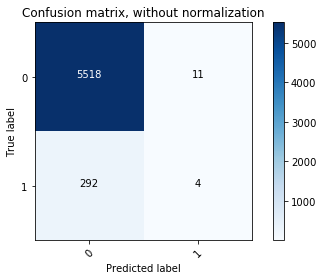

In [91]:
predictions = cross_val_predict(random_forest, X_test, y_test, cv=3)
cnf_matrix = confusion_matrix(y_test, predictions)
class_names = ['0', '1']
# plt.figure(figsize=(14, 7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

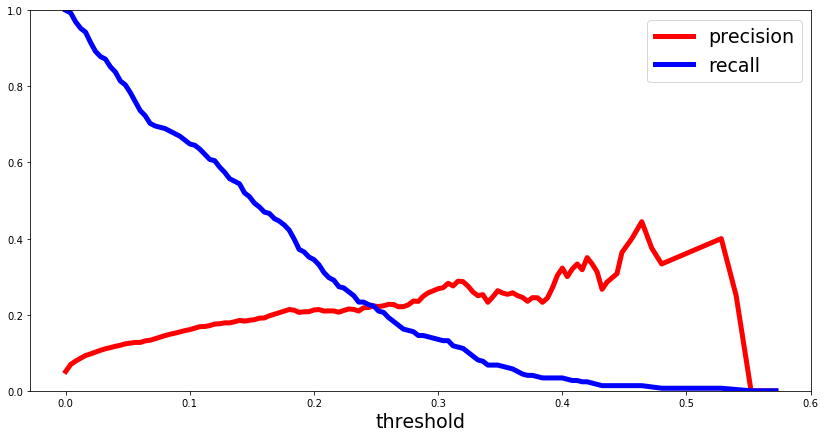

In [82]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores_orig = random_forest.predict_proba(X_test)
y_scores = y_scores_orig[:,1]
#y_scores = (y_scores_orig [:,1] >= threshold1).astype('int')
#Si no hay ningún 1 da Warning y no se plotea nada
precision, recall, threshold = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)

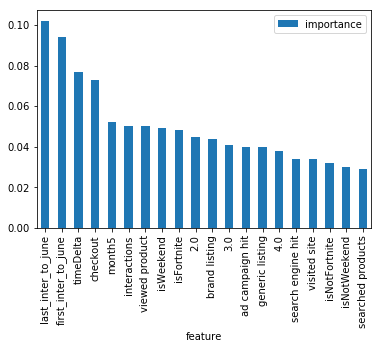

In [84]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
#plt.figure()
importances.plot.bar()
plt.show()

In [85]:
# Vuelvo a crear el objeto random_forest
# Random Forest
n_estimators = 150
random_forest = runRandomForests(X_train, y_train, X_test, y_test, n_estimators = n_estimators)
y_prediction = random_forest.predict(X_test)

Mean Absolute Error: 0.05 degrees.
100.0 %


Confusion matrix, without normalization
[[5513   16]
 [ 295    1]]


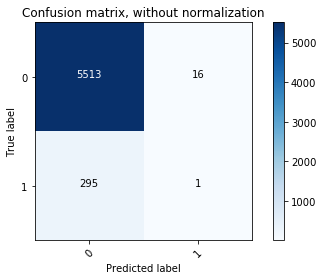

In [92]:
predictions = cross_val_predict(random_forest, X_test, y_test, cv=3)
cnf_matrix = confusion_matrix(y_test, predictions)
class_names = ['0', '1']
# plt.figure(figsize=(14, 7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

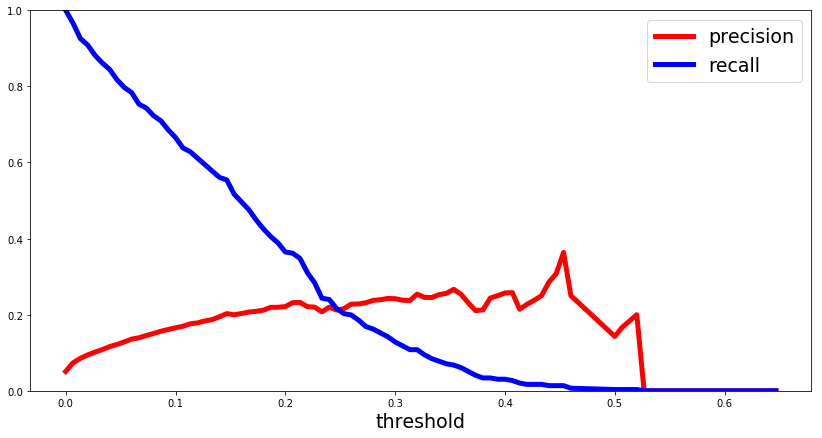

In [87]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores_orig = random_forest.predict_proba(X_test)
y_scores = y_scores_orig[:,1]
#y_scores = (y_scores_orig [:,1] >= threshold1).astype('int')
#Si no hay ningún 1 da Warning y no se plotea nada
precision, recall, threshold = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)

In [88]:
# Vuelvo a crear el objeto random_forest
# Random Forest
n_estimators = 50
random_forest = runRandomForests(X_train, y_train, X_test, y_test, n_estimators = n_estimators)
y_prediction = random_forest.predict(X_test)

Mean Absolute Error: 0.05 degrees.
100.0 %


Confusion matrix, without normalization
[[5516   13]
 [ 291    5]]


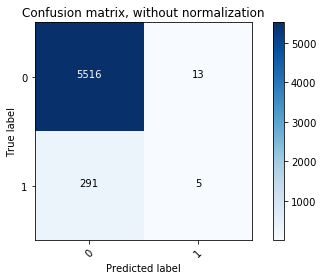

In [93]:
predictions = cross_val_predict(random_forest, X_test, y_test, cv=3)
cnf_matrix = confusion_matrix(y_test, predictions)
class_names = ['0', '1']
# plt.figure(figsize=(14, 7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

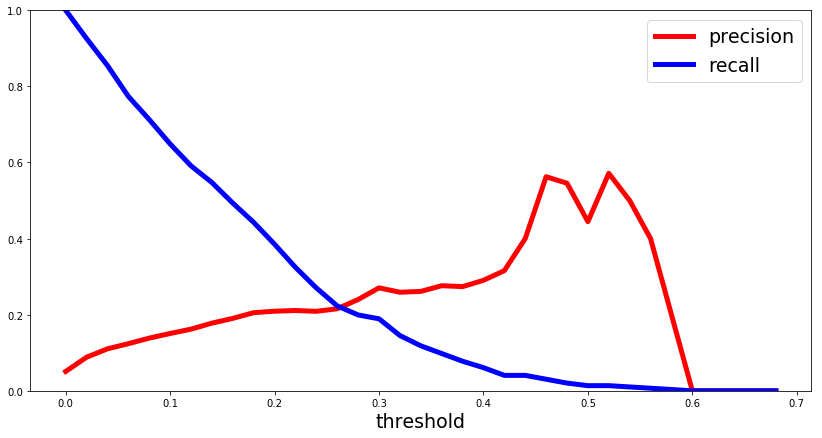

In [90]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores_orig = random_forest.predict_proba(X_test)
y_scores = y_scores_orig[:,1]
#y_scores = (y_scores_orig [:,1] >= threshold1).astype('int')
#Si no hay ningún 1 da Warning y no se plotea nada
precision, recall, threshold = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)

In [28]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_test, Y_pred) * 100, 2)
print(round(acc_log,2,), "%")



100.0 %


In [29]:
predictions = cross_val_predict(logreg, X_test, y_test, cv=3)
cnf_matrix = confusion_matrix(y_test, predictions)

Confusion matrix, without normalization
[[5529    0]
 [ 296    0]]


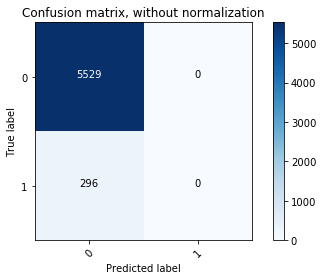

In [30]:
class_names = ['0', '1']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')